# Contributors
Zijian Zhang 14851598 $\\$
Amish Sewlal 13297503 $\\$
Ravi Sharma Kaushik 14332744

# Creating Mandlebrot Set

# Area of Mandlebrot Set using Monte Carlo Method

# Convergence studies for various number of iterations and samples

# Using varous sampling techniques  

# Approach for improving convergence

In [1]:
import math
import matplotlib.pyplot as plt
from numba import jit
import numpy as np
from Mandelbrot_h import whenLeaveMandelbrotSet as wlms

In [16]:
def RS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by pure random sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    history = np.zeros((s_num, iter_num))
    # history is the historical data for all samples at each step in the iteration
    for s in range(s_num):
        U1 = np.random.uniform(0, 1)
        U2 = np.random.uniform(0, 1)
        theta = U1 * 2 * math.pi
        r = R * math.sqrt(U2)
        real = r * math.cos(theta)
        imag = r * math.sin(theta)
        c = complex(real, imag)
        j = wlms(c, iter_num)
        # j is the iteration number when c leave the Mandelbrot set
        # If c never leave the Mandelbrot set, j = iter_num
        history[s, :j] = 1

    # Compute the area of the Mandelbrot set
    N_h = history.sum(axis=0)
    # N_h is the number of samples that are in the Mandelbrot set during the run
    A_total = math.pi * R**2  # The area of the sampling region
    A_h = N_h / s_num * A_total

    return A_h


def LHS_circle(iter_num: int, s_num: int, R: int = 2) -> np.ndarray:
    '''Compute the area of the Mandelbrot set by Latin hypercube sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    idx = np.arange(s_num)
    np.random.shuffle(idx)
    history = np.zeros((s_num, iter_num))
    # history is the historical data for all samples at each step in the iteration
    for s in range(s_num):
        U1 = np.random.uniform(0, 1)
        U2 = np.random.uniform(0, 1)
        # Split the circular sampling region into s sectors, and get the RV: theta
        theta = 2 * math.pi * (s + U1) / s_num
        # Divide the sector into s equal parts of equal area, and get the RV: r
        r = R * math.sqrt((idx[s] + U2) / s_num)
        real = r * math.cos(theta)
        imag = r * math.sin(theta)
        c = complex(real, imag)
        j = wlms(c, iter_num)
        # j is the iteration number when c leave the Mandelbrot set
        # If c never leave the Mandelbrot set, j = iter_num
        history[s, :j] = 1

    # Compute the areas of the Mandelbrot set during the run
    N_h = history.sum(axis=0)
    # N_h is the number of samples that are in the Mandelbrot set during the run
    A_total = math.pi * R**2  # The area of the sampling region
    A_h = N_h / s_num * A_total

    return A_h


# TODO: Implement IS_circle()
def IS_circle():
    '''Compute the area of the Mandelbrot set by importance sampling within a circle.
    Parameters:
        iter_num: the number of iterations (i)
        s_num: the number of samples (s)
        R: the radius of the circle
    Returns:
        A_h: the areas of the Mandelbrot set during the run
    '''
    pass

In [8]:
# Please ignore this unit
s = 2
i = 10
a = np.zeros((s, i))
j = 10
a[0, :j] = 1  # j == i means the sample 0 never leave the Mandelbrot set
j = 3
a[1, :j] = 1
N_h = a.sum(axis=0)
print(a)
print(N_h)

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 0. 0. 0. 0. 0. 0. 0.]]
[2. 2. 2. 1. 1. 1. 1. 1. 1. 1.]


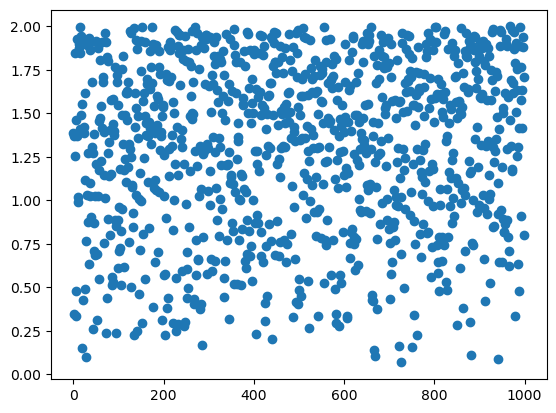

In [37]:
# Please ignore this unit
def test():
    s_num = 5
    R = 2
    s = 0
    idx = np.arange(s_num)
    np.random.shuffle(idx)
    U2 = np.random.uniform(0, 1)
    r = R * math.sqrt((idx[s] + U2) / s_num)
    return r


xs = np.arange(1000)
rs = []
for x in xs:
    rs.append(test())

plt.figure()
plt.scatter(xs, rs)
plt.show()

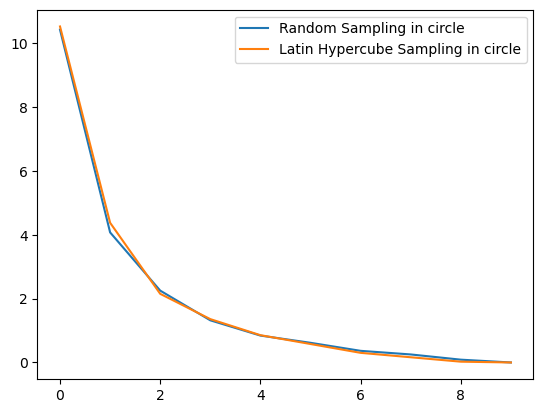

In [114]:
# Compare the convergence rate of the two methods
i = 10
s = 100
x = np.arange(i)
y1 = []
y2 = []
for j in range(10):
    A_h_RSC = RS_circle(i, s, R=2)
    A_h_LHSC = LHS_circle(i, s, R=2)
    y1.append(np.abs(A_h_RSC - A_h_RSC[-1]))
    y2.append(np.abs(A_h_LHSC - A_h_LHSC[-1]))
y1 = np.mean(y1, axis=0)
y2 = np.mean(y2, axis=0)

plt.figure()
plt.plot(x, y1, label="Random Sampling in circle")
plt.plot(x, y2, label="Latin Hypercube Sampling in circle")
plt.legend()
plt.show()
# The two convergence curves look similar

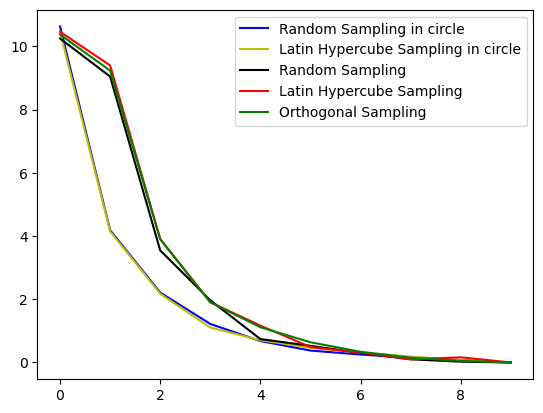

In [120]:
# Compare the convergence rate of the five methods
from MonteCarloIntegration import randomSampling as RS, latinHypercubeSampling as LHS, orthogonalSampling as OS

i = 10
s = 1000
x = np.arange(i)
l = round(np.sqrt(4*math.pi)/2, 2)  # Make the sampling area the same size

A_h_RSC = RS_circle(i, s, R=2)
A_h_LHSC = LHS_circle(i, s, R=2)
A_h_RS, A_h_LHS, A_h_OS = [], [], []
for k in range(i):
    A_h_RS.append(RS(-l, l, k, s))
    A_h_LHS.append(LHS(-l, l, k, s))
    A_h_OS.append(OS(-l, l, k, s))
A_h_RS = np.array(A_h_RS)
A_h_LHS = np.array(A_h_LHS)
A_h_OS = np.array(A_h_OS)
y1 = np.abs(A_h_RSC - A_h_RSC[-1])
y2 = np.abs(A_h_LHSC - A_h_LHSC[-1])
y3 = np.abs(A_h_RS - A_h_RS[-1])
y4 = np.abs(A_h_LHS - A_h_LHS[-1])
y5 = np.abs(A_h_OS - A_h_OS[-1])

plt.figure()
plt.plot(x, y1, label="Random Sampling in circle", c='b')
plt.plot(x, y2, label="Latin Hypercube Sampling in circle", c='y')
plt.plot(x, y3, label="Random Sampling", c='k')
plt.plot(x, y4, label="Latin Hypercube Sampling", c='r')
plt.plot(x, y5, label="Orthogonal Sampling", c='g')
plt.legend()
plt.show()
# New methods look better than the previous three